In [1]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

# from tqdm.notebook import tqdm 
# 
# import tqdm as notebook_tqdm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [8, 5] # 12, 7
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = "retina"

# Basic Concepts

## White Noise

**Definition**: a time series is characterized as **white noise** when it 
consists of a sequence of uncorrelated random variables, commonly modeled as 
Gaussian (normal) random variables:

$$
x_t = \epsilon_t \\
\epsilon_t \sim N(0, \sigma)
$$

*Observations*:

* **Mean**: The series has a mean of **zero**.
* **Constant Variance**: The variance of the series remains constant and finite 
over time.
* **No Autocorrelation**: There is no predictable pattern or trend in the series.
Each value is statistically independent of other values, implying no correlation 
between past, present, and future values in the series.



## Random Walk

**Definition**: A time series is characterized as following a **random walk** if, 
and only if, the difference between its consecutive values (i.e., the variation 
at each time step) constitutes *white noise*. 

$$
x_t - x_{t-1} = \epsilon_t \\
\epsilon_t \sim N(0, \sigma)
$$

*Observation*: This implies that the changes in the series from one period to the 
next are entirely random and unpredictable, with no discernible pattern or trend, 
meaning that *each change* is **independent** of *past changes*.

# Basic Structural Time Series Model

**Definition** - the **Basic Structural Model** is a framework in time series 
analysis that decomposes a time series into three distinct components: **trend**, 
**cycle**, and **noise**.

$$
y_t = \mu_t + \gamma_t + \epsilon_t
$$

* $\mu_t$: **trend** represents the long-term progression of the series.
* $\gamma_t$: **cycle** accounts for regular but not necessarily seasonal 
fluctuations in the time series.
* $\epsilon_t \sim N(0, \sigma_{\epsilon})$: This is the **random error**, the 
**noise** or the **irregular component** of the series.

## Trends
### Stochastic Trend

The **1-step changes in the trend** are modeled as **random walk** plus 
**white noise**:

$$
\mu_t - \mu_{t-1} = \beta_t + \xi_t \\
\beta_t - \beta_{t-1} = \eta_t
$$

Where:

$$
\xi_t \sim N(0, \sigma_{\mu}) \\
\eta_t \sim N(0, \sigma_{\beta})
$$

Alternatively:

$$
\mu_t \sim N(\mu_{t-1} + \beta_t, \sigma_{\mu}) \\
\beta_t \sim N(\beta_{t-1}, \sigma_{\beta})
$$

*Observation*
Here it is usual to distinguish between:
* **(Local) Level**, $\mu_t$: The baseline value of the series, representing its 
**long-term** average or trend.
* **(Local) Trend**, $\beta_t$: A component that captures the gradual, long-term 
movement in the series. Unlike the level, which is more static, the trend is 
dynamic and can change over time, representing either an upward or downward 
direction in the data.


### Local Level Trend

If $\beta_0 = 0$ and $\sigma_{\beta} = 0$, the stochastic trend is called
*Local Level Trend*.

The **trend** is a **random walk** (equivalent to: "the **1-step changes** in the
trend are modeled as **white noise**"): 

$$
\mu_t - \mu_{t-1} = \xi_t
$$

With:

$$
\xi_t \sim N(0, \sigma_{\mu})
$$

Alternatively:

$$
\mu_t \sim N(\mu_{t-1}, \sigma_{\mu})
$$


## Cycles

# Simulation

In [3]:
import numpy as np
import pandas as pd

def stochastic_trend(
        rng, 
        N = 100, 
        sigma_local_trend = 1, 
        local_trend_0 = 1, 
        sigma_local_level = 1, 
        local_level_0 = 100
        ):
    """Simulate a stochastic trend

    Args:
        rng (_type_): _description_
        N (int, optional): _description_. Defaults to 100.
        sigma_local_trend (int, optional): _description_. Defaults to 1.
        sigma_local_level (int, optional): _description_. Defaults to 1.
        local_level_0 (int, optional): _description_. Defaults to 100.
        local_trend_0 (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    # local trend is a random walk
    diff_local_trend = rng.normal(0, sigma_local_trend, N)
    local_trend      = np.cumsum(diff_local_trend) + local_trend_0

    # local level is the local trend plus noise
    diff_local_level = rng.normal(local_trend, sigma_local_level, N)
    local_level      = np.cumsum(diff_local_level) + local_level_0

    # dataframe with t = 1:N, local_trend, local_level
    df = pd.DataFrame(
        {
            "t": np.arange(1, N + 1),
            "local_trend": local_trend,
            "local_level": local_level,
        }
    )
    return df

def plot_stochastic_trend(df):
    """plot local_trend and local_level vs t, each with a different y-axis

    Args:
        df (_type_): _description_
    """
    # plot local_trend and local_level vs t, each with a different y-axis
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    df.plot(x="t", y=["local_trend"], ax=ax1, alpha=0.5)
    df.plot(x="t", y=["local_level"], ax=ax2, alpha=0.5, color="C1")

    # Add y-axis labels
    ax1.set_ylabel("local_trend")
    ax2.set_ylabel("local_level")

    # Add a legend
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    # Add a title
    plt.title("Local Trend and Local Level")

    # Add horizontal dotted line at local_trend = 0
    ax1.axhline(0, linestyle="--", color="black", alpha=0.5)

    fig.tight_layout()
    plt.show()

def local_level_trend(
        rng, 
        N = 100, 
        sigma = 1, 
        level_0 = 100
        ):
    """simulate a local level trend

    Args:
        rng (_type_): _description_
        N (int, optional): _description_. Defaults to 100.
        sigma_local_trend (int, optional): _description_. Defaults to 1.
        sigma_local_level (int, optional): _description_. Defaults to 1.
        local_level_0 (int, optional): _description_. Defaults to 100.
        local_trend_0 (int, optional): _description_. Defaults to 1.
    """

    df = stochastic_trend(
        rng, 
        N = N, 
        sigma_local_trend = 0, 
        local_trend_0 = 0, 
        sigma_local_level = sigma, 
        local_level_0 = level_0
    )

    return df

def deterministic_trend(
        rng,
        N = 100,
        slope = 1,
        intercept = 100
):
    """simulate a deterministic trend
    """

    df = stochastic_trend(
        rng, 
        N = N, 
        sigma_local_trend = 0, 
        local_trend_0 = slope, 
        sigma_local_level = 0, 
        local_level_0 = intercept
    )

    return df



In [4]:
RANDOM_SEED = 11111
rng = np.random.default_rng(RANDOM_SEED)

## Stochastic Trend

C:\Users\mcondedesimon\AppData\Local\Temp\ipykernel_15420\2552559127.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


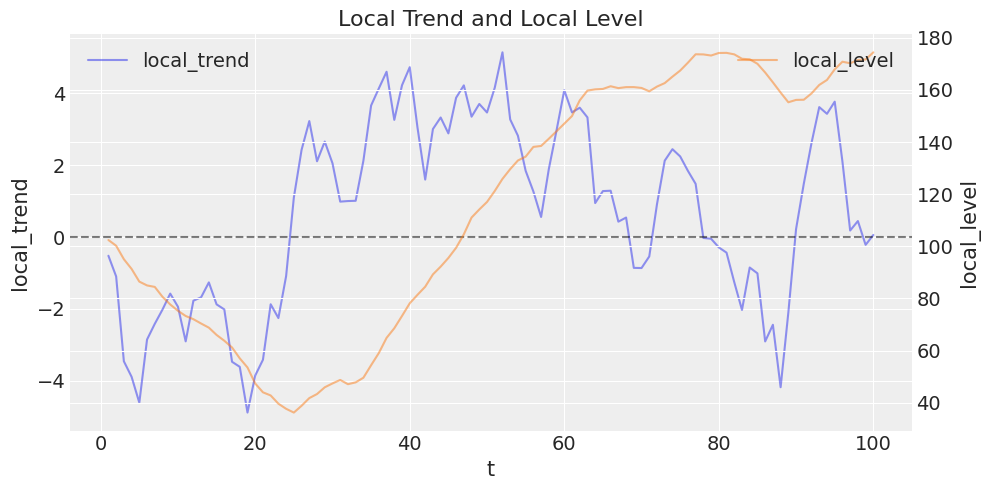

In [5]:
df_stoch_trend = stochastic_trend(
    rng, 
    N = 100, 
    sigma_local_trend = 1, 
    local_trend_0 = 1, 
    sigma_local_level = 1, 
    local_level_0 = 100
    )

plot_stochastic_trend(df_stoch_trend)

C:\Users\mcondedesimon\AppData\Local\Temp\ipykernel_15420\2552559127.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


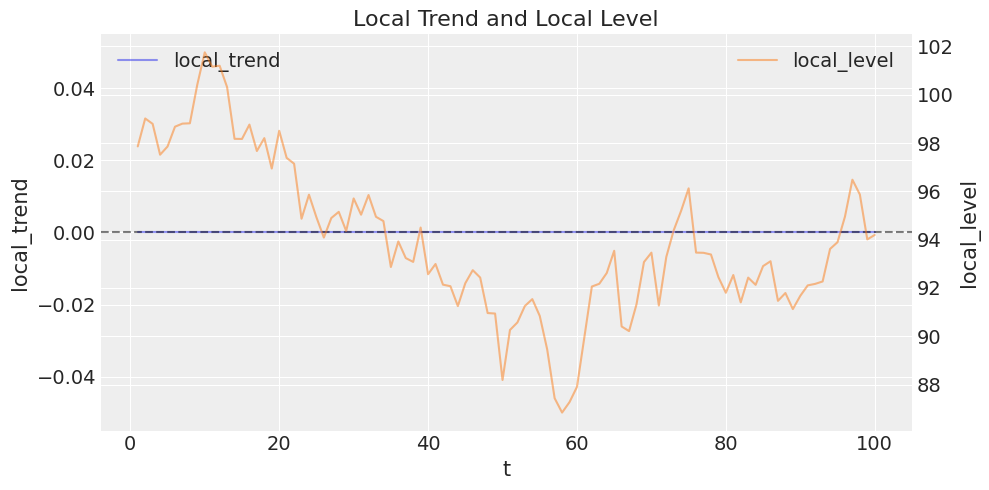

In [6]:
df_local_level_trend = local_level_trend(
    rng, 
    N = 100, 
    sigma = 1, 
    level_0 = 100
    )

plot_stochastic_trend(df_local_level_trend)

C:\Users\mcondedesimon\AppData\Local\Temp\ipykernel_15420\2552559127.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


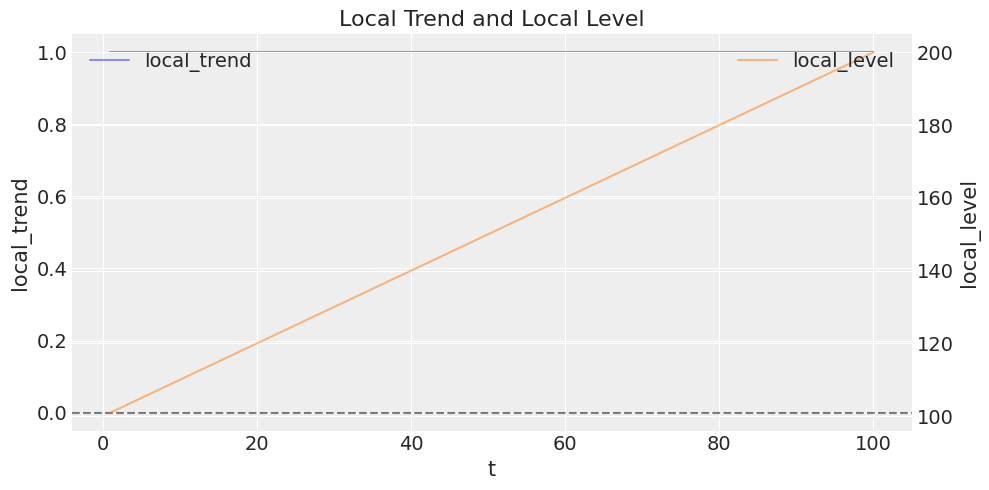

In [7]:
df_deterministic_trend = deterministic_trend(
    rng, 
    N = 100, 
    slope = 1, 
    intercept = 100
    )

plot_stochastic_trend(df_deterministic_trend)

### Cycles

In [8]:
# Dataframe con columna 'fecha' desde 2021-01-01 hasta 2023-11-30, con frecuencia semanal
df = pd.DataFrame(
    {
        "fecha": pd.date_range(start="2021-01-01", end="2023-11-30", freq="D")
    }
)

# Agregamos columna 't' con el número de semana
df["t"] = df.index + 1

# Agregamos el dia de la semana como string
df["dia_semana"] = df["fecha"].dt.day_name()

# Agregamos el dia de la semana como numero
df["dia_semana_num"] = df["fecha"].dt.dayofweek + 1

df.head()

fecha  t dia_semana  dia_semana_num
0 2021-01-01  1     Friday               5
1 2021-01-02  2   Saturday               6
2 2021-01-03  3     Sunday               7
3 2021-01-04  4     Monday               1
4 2021-01-05  5    Tuesday               2

In [9]:
def make_fourier_features(df, date_var_name, n_order=10, period=365.25):
    """
    Generate Fourier features based on a given date variable in a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the date variable.
        date_var_name (str): The name of the date variable column in the DataFrame.
        n_order (int, optional): The number of Fourier orders to generate. Defaults to 10.
        period (float, optional): The period of the Fourier series. Defaults to 365.25.

    Returns:
        pandas.DataFrame: A DataFrame containing the Fourier features.
    """
    # Calculate the periods based on the date variable
    periods = (df[date_var_name] - pd.Timestamp("1900-01-01")).dt.days / period

    # Generate the Fourier features using sine and cosine functions
    fourier_features = pd.DataFrame(
        {
            f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
            for order in range(1, n_order + 1)
            for func in ("sin", "cos")
        }
    )

    return fourier_features

<Axes: xlabel='fecha'>

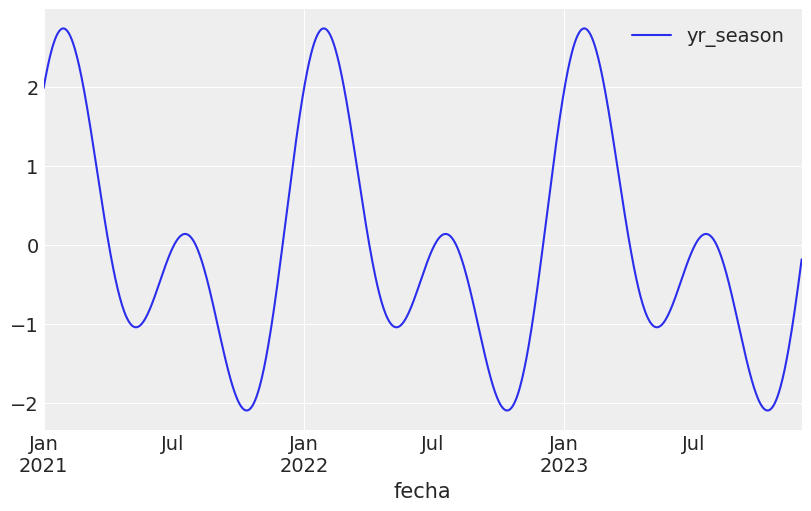

In [10]:
fourier_features = make_fourier_features(df, "fecha", n_order=2, period=365.25)

# genera un numpy array con shape (1, df.shape[0]) yllénalo con valores aleatorios
fourier_coefs = np.array(rng.uniform(0, 1, fourier_features.shape[1]))
fourier_coefs = np.array(fourier_features.shape[1]*[1.0])

# Multiplica matricialmente las fourier_features por four_coefs
df['yr_season'] = np.dot(fourier_features, fourier_coefs)

df.plot(x="fecha", y=["yr_season"])


# Modeling

## Trend

In [160]:
df = df_stoch_trend.assign(y = lambda x: x.local_level + rng.normal(0, 1, 100))

In [12]:
df.head()

t  local_trend  local_level           y
0  1    -0.521628   102.402626  103.090206
1  2    -1.095988   100.213918  100.176089
2  3    -3.458094    95.041352   95.357463
3  4    -3.890317    91.306045   90.350359
4  5    -4.609461    86.437916   86.573733

<Axes: xlabel='t'>

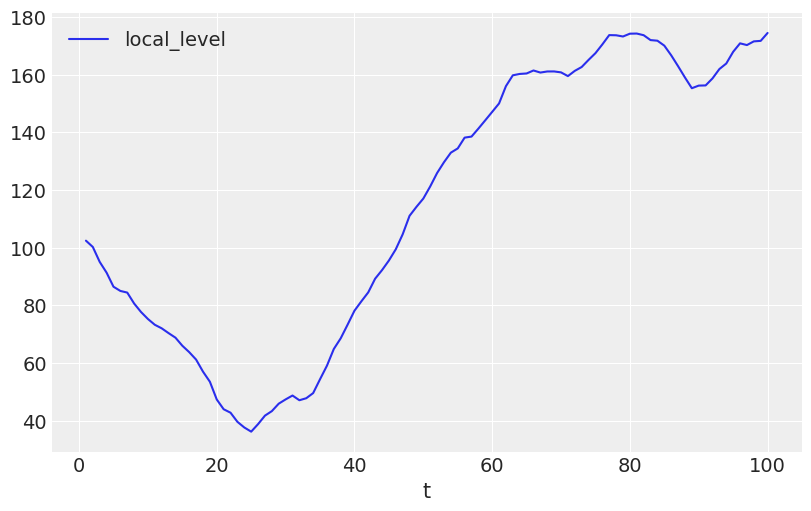

In [161]:
df.plot(x="t", y=["local_level"])

### 0 - Scale the data

In [162]:
t = df["t"].to_numpy()

# Max-min scaling
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

In [163]:
# Next, for the target variable, we divide by the maximum. We do this, rather 
# than standardising, so that the sign of the 
# observations in unchanged - this will be necessary for the seasonality 
# component to work properly later on.
y = df["y"].to_numpy()
y_max = np.max(y)
y_min = np.min(y)
y = y / y_max

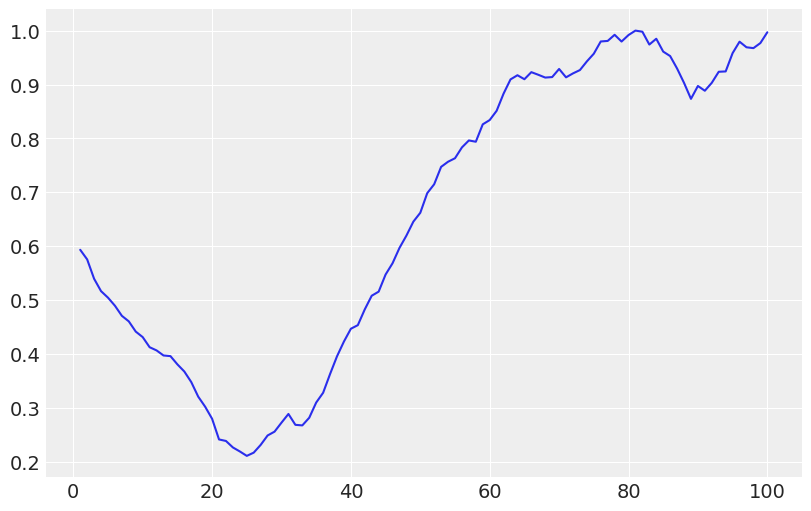

In [164]:
plt.plot(df['t'], y)

### 1 - Model

In [165]:
T = y.shape[0]

sigma_lt_0 = 1 / 4 / T

mu_ll_0 = y[0]
sigma_ll_0 = 0.68 * (1 - y_min/y_max)

sigma_lt = np.std(np.diff(y))
sigma_ll = sigma_lt

sigma_epsilon = np.std(y)

print(f"y_max      = {y_max}")
print(f"y_min      = {y_min}")
print(f"T          = {T}")
print(f"sigma_lt_0 = {sigma_lt_0}")
print(f"mu_ll_0    = {mu_ll_0}")
print(f"sigma_ll_0 = {sigma_ll_0}")
print(f"sigma_lt   = {sigma_lt}, lam_lt = {1 / sigma_lt}")
print(f"sigma_ll   = {sigma_ll}, lam_ll = {1 / sigma_ll}")

print(f"sigma   = {sigma_epsilon}, lam_sigma = {1 / sigma_epsilon}")

y_max      = 175.44221300110732
y_min      = 37.043551505720224
T          = 100
sigma_lt_0 = 0.0025
mu_ll_0    = 0.5933936980379731
sigma_ll_0 = 0.536422154092808
sigma_lt   = 0.018512219211969903, lam_lt = 54.01837502839234
sigma_ll   = 0.018512219211969903, lam_ll = 54.01837502839234
sigma   = 0.2747374819421101, lam_sigma = 3.63983826644633


In [175]:
coords = {'n_obs': df.index}

with pm.Model(coords=coords, check_bounds=False) as stochastic_trend_model:

    # sigma_local_trend = pm.Exponential("sigma_local_trend", lam=y_max * 1)  # 20
    # sigma_local_level = pm.Exponential("sigma_local_level", lam=y_max * 1)  # 20
    # sigma             = pm.Exponential("sigma", lam=y_max * 1)              # .1
    sigma_local_trend = pm.Exponential("sigma_local_trend", lam=1/sigma_lt)  
    sigma_local_level = pm.Exponential("sigma_local_level", lam=1/sigma_ll)  
    sigma             = pm.Exponential("sigma", lam=1/sigma_epsilon)              

    # local_trend_0    = pm.Normal("local_trend_0", mu=0, sigma=1e-1)
    local_trend_0    = pm.Normal("local_trend_0", mu=0, sigma=sigma_lt_0)
    diff_local_trend = pm.Normal("diff_local_trend", mu=0, sigma=sigma_local_trend, dims="n_obs")
    local_trend      = pm.Deterministic("local_trend", diff_local_trend.cumsum() + local_trend_0, dims="n_obs")
    
    # local_level_0    = pm.Normal("local_level_0", mu=0, sigma=.5)
    local_level_0    = pm.Normal("local_level_0", mu=mu_ll_0, sigma=sigma_ll_0)
    diff_local_level = pm.Normal("diff_local_level", mu=local_trend, sigma=sigma_local_level, dims="n_obs")
    local_level      = pm.Deterministic("local_level", diff_local_level.cumsum() + local_level_0, dims="n_obs")

    y_obs = pm.Normal("y_obs", mu=local_level, sigma=sigma, dims="n_obs", observed=y)

    stochastic_trend_prior = pm.sample_prior_predictive()

Sampling: [diff_local_level, diff_local_trend, local_level_0, local_trend_0, sigma, sigma_local_level, sigma_local_trend, y_obs]


In [19]:
stochastic_trend_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

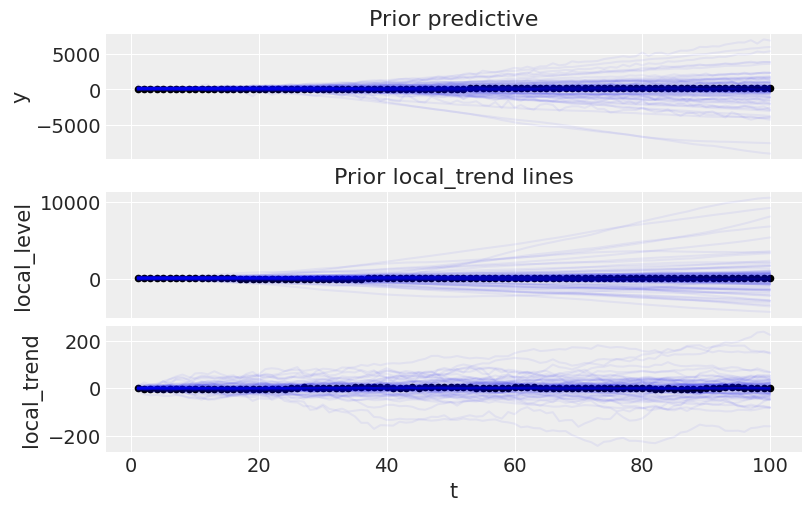

In [176]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(stochastic_trend_prior, group="prior_predictive", num_samples=100)["y_obs"]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["t"],
    az.extract(stochastic_trend_prior, group="prior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Prior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(stochastic_trend_prior, group="prior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[1].set_title("Prior local_trend lines");

In [177]:
with stochastic_trend_model:
    # inference data, trace, posterior
    idata = pm.sample(
        return_inferencedata=True, 
        target_accept=0.9,
        draws=12000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True}
        )
    # ppc predictive check
    ppc = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time = 0:00:01.902328
Sampling...


  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

Sampling time = 0:01:57.630594
Transforming variables...
Transformation time = 0:00:00.826514
Computing Log Likelihood...
Log Likelihood time = 0:00:00.624454
Sampling: [y_obs]


In [22]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [23]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

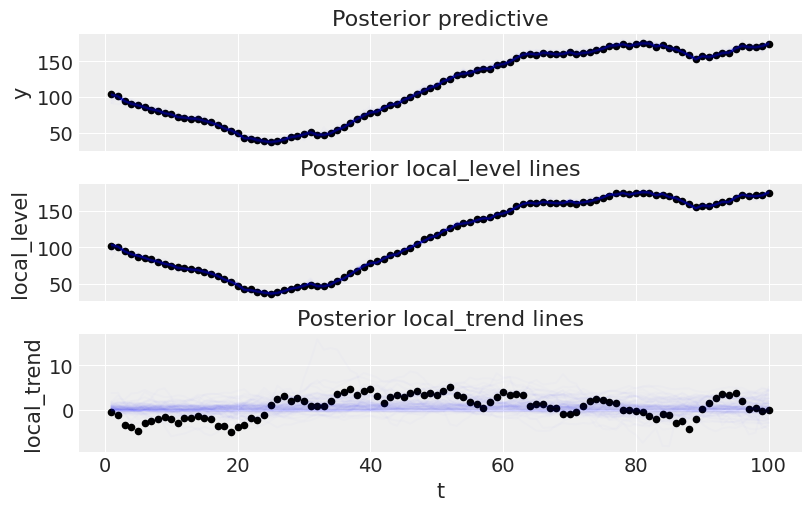

In [173]:

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(ppc, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["t"],
    az.extract(idata, group="posterior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Posterior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(idata, group="posterior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[2].set_title("Posterior local_trend lines");

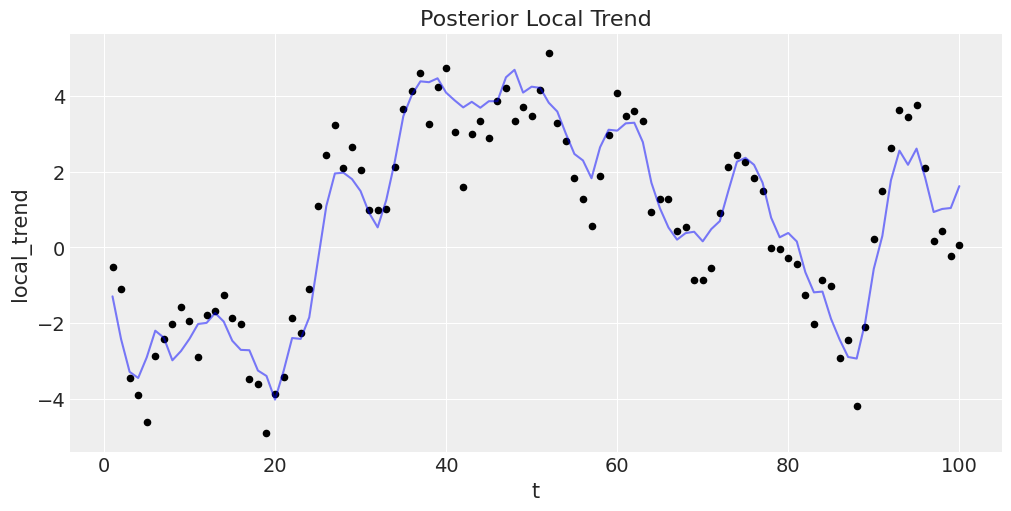

In [25]:
posterior_avg_trend = y_max*idata.posterior['local_trend'].mean(dim=['chain', 'draw'])
posterior_avg_trend

# plot ppc_avg_trend and y vs t
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["t"], posterior_avg_trend, color="blue", alpha=0.5)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax)
ax.set_title("Posterior Local Trend")
ax.set_ylabel("local_trend")
ax.set_xlabel("t");

In [26]:
az.summary(idata, var_names=['sigma_local_trend', 'sigma_local_level', 'local_trend_0', 'local_level_0', 'sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma_local_trend  0.006  0.001   0.004    0.009        0.0      0.0   
sigma_local_level  0.008  0.004   0.001    0.013        0.0      0.0   
local_trend_0     -0.001  0.002  -0.006    0.004        0.0      0.0   
local_level_0      0.590  0.012   0.568    0.613        0.0      0.0   
sigma              0.005  0.002   0.002    0.008        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
sigma_local_trend     159.0    2139.0   1.03  
sigma_local_level      67.0      81.0   1.06  
local_trend_0       18830.0   33016.0   1.00  
local_level_0        5541.0    8654.0   1.00  
sigma                 142.0     249.0   1.04

In [27]:
az.summary(idata, var_names=['sigma_local_trend', 'sigma_local_level', 'local_trend_0', 'local_level_0', 'sigma'])*y_max

mean        sd      hdi_3%     hdi_97%  mcse_mean  \
sigma_local_trend    1.058523  0.176420    0.705682    1.587784        0.0   
sigma_local_level    1.411363  0.705682    0.176420    2.293466        0.0   
local_trend_0       -0.176420  0.352841   -1.058523    0.705682        0.0   
local_level_0      104.088050  2.117045  100.206801  108.145720        0.0   
sigma                0.882102  0.352841    0.352841    1.411363        0.0   

                   mcse_sd      ess_bulk      ess_tail       r_hat  
sigma_local_trend      0.0  2.805085e+04  3.773633e+05  181.713037  
sigma_local_level      0.0  1.182017e+04  1.429005e+04  187.005650  
local_trend_0          0.0  3.321997e+06  5.824697e+06  176.420425  
local_level_0          0.0  9.775456e+05  1.526742e+06  176.420425  
sigma                  0.0  2.505170e+04  4.392869e+04  183.477242

In [28]:
az.summary(ppc, var_names=['y_obs'])

c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\arviz\stats\stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
y_obs[0]   0.583  0.008   0.568    0.597        0.0      0.0   17106.0   
y_obs[1]   0.566  0.007   0.551    0.579        0.0      0.0   13642.0   
y_obs[2]   0.541  0.007   0.527    0.554        0.0      0.0   30117.0   
y_obs[3]   0.514  0.007   0.501    0.529        0.0      0.0    5113.0   
y_obs[4]   0.495  0.007   0.482    0.511        0.0      0.0    2462.0   
...          ...    ...     ...      ...        ...      ...       ...   
y_obs[95]  0.970  0.008   0.955    0.983        0.0      0.0    2342.0   
y_obs[96]  0.966  0.007   0.953    0.980        0.0      0.0    4109.0   
y_obs[97]  0.973  0.007   0.959    0.986        0.0      0.0   20074.0   
y_obs[98]  0.973  0.007   0.960    0.988        0.0      0.0    2996.0   
y_obs[99]  0.988  0.008   0.973    1.002        0.0      0.0   16944.0   

           ess_tail  r_hat  
y_obs[0]     9520.0   1.01  
y_obs[1]    10440.0   1.00  
y_obs[2]    16770.0   1.01  
y_obs[3]     7907.0   1.00  
y_obs[4]     6874.0   1.00  
...             ...    ...  
y_obs[95]    7002.0   1.01  
y_obs[96]   10516.0   1.00  
y_obs[97]   13490.0   1.00  
y_obs[98]    8497.0   1.00  
y_obs[99]    9056.0   1.00  

[100 rows x 9 columns]

### Alternativa que no funciona

In [39]:
coords = {'n_obs': df.index}

with pm.Model(coords=coords, check_bounds=True) as stochastic_trend_model_2:

    # Define the standard deviation for the trend, level and signal noises
    sigma_local_trend = pm.HalfNormal('sigma_local_trend', sigma=sigma_lt / np.sqrt(1 - 2 / np.pi))
    sigma_local_level = pm.HalfNormal('sigma_local_level', sigma=sigma_ll / np.sqrt(1 - 2 / np.pi))
    sigma             = pm.HalfNormal('sigma', sigma=sigma_epsilon / np.sqrt(1 - 2 / np.pi))

    # Define the Gaussian Random Walk for the trend
    local_trend = pm.GaussianRandomWalk(
        name  = 'local_trend', 
        sigma = sigma_local_trend, 
        dims  = 'n_obs', 
        # init_dist = pm.Normal.dist(mu=0, sigma=1),
        )

    # Define the level as the trend plus Gaussian noise
    local_level_0 = pm.GaussianRandomWalk(
        name  = 'local_level_0', 
        # mu    = local_trend, # Este es el que da problemas
        sigma = sigma_local_level, 
        dims  = 'n_obs', 
        # init_dist = pm.Normal.dist(mu=0, sigma=1),
        ) 
    
    local_level = pm.Deterministic("local_level", local_level_0 + local_trend, dims = "n_obs")
    
    # Likelihood
    y_obs = pm.Normal(
        name     =  "y_obs", 
        mu       = local_level, 
        sigma    = sigma, 
        # dims     = "n_obs", 
        observed = y,
        )
    
    stochastic_trend_prior2 = pm.sample_prior_predictive()


c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Sampling: [local_level_0, local_trend, sigma, sigma_local_level, sigma_local_trend, y_obs]


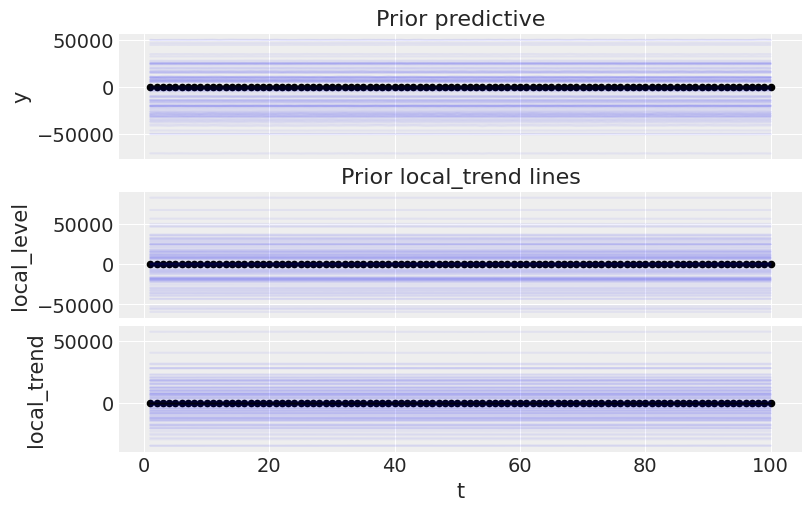

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(stochastic_trend_prior2, group="prior_predictive", num_samples=100)["y_obs"]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["t"],
    az.extract(stochastic_trend_prior2, group="prior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Prior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(stochastic_trend_prior2, group="prior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[1].set_title("Prior local_trend lines");

In [41]:
RANDOM_SEED = 99999
rng = np.random.default_rng(RANDOM_SEED)

with stochastic_trend_model_2:
    idata2 = pm.sample(
        return_inferencedata=True, 
        # target_accept=0.9,
        draws=3000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True},
        )
    ppc2 = pm.sample_posterior_predictive(trace=idata2)

Compiling...
Compilation time = 0:00:04.230001
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time = 0:00:32.089187
Transforming variables...
Transformation time = 0:00:00.317827
Computing Log Likelihood...
Log Likelihood time = 0:00:00.470920
Sampling: [y_obs]


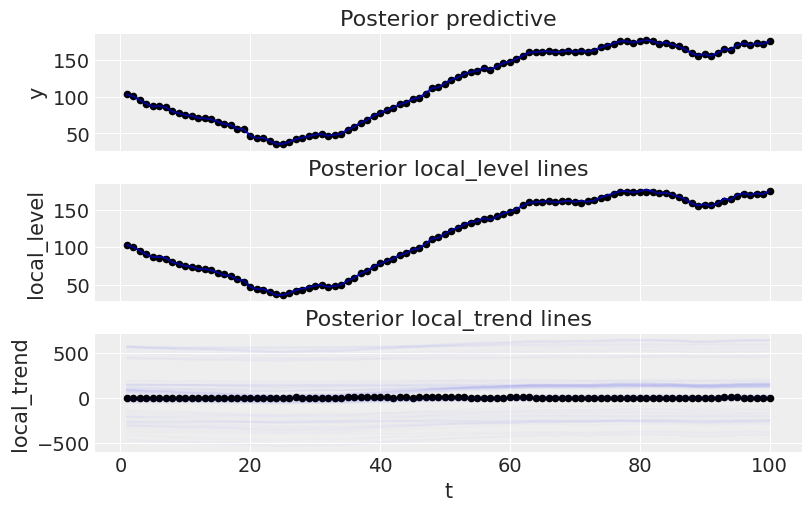

In [42]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(ppc2, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["t"],
    az.extract(idata2, group="posterior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Posterior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(idata2, group="posterior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[2].set_title("Posterior local_trend lines");

In [43]:
idata2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

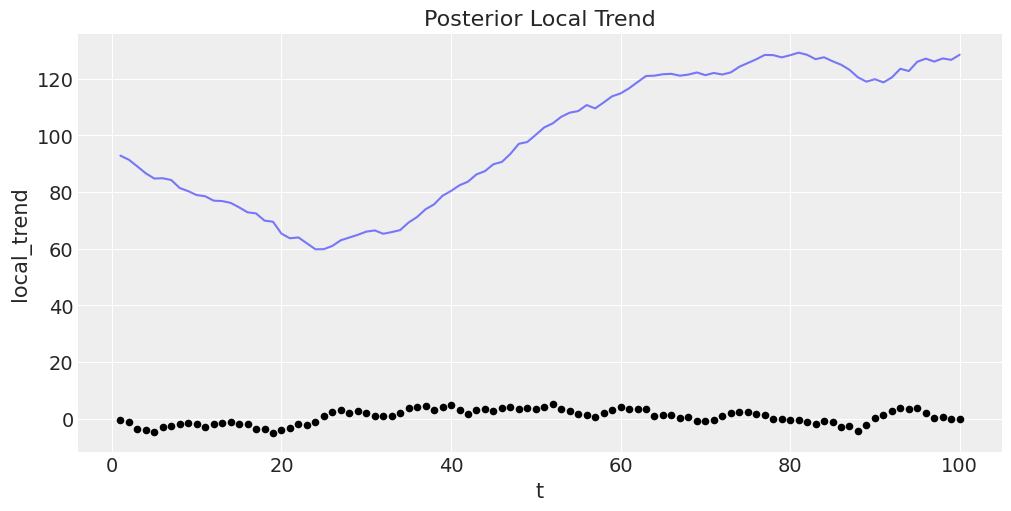

In [44]:
posterior_avg_trend2 = y_max*idata2.posterior['local_trend'].mean(dim=['chain', 'draw'])
posterior_avg_trend2

# plot ppc_avg_trend and y vs t
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["t"], posterior_avg_trend2, color="blue", alpha=0.5)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax)
ax.set_title("Posterior Local Trend")
ax.set_ylabel("local_trend")
ax.set_xlabel("t");

In [45]:
az.summary(idata2, var_names=['sigma_local_trend', 'sigma_local_level', 'sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma_local_trend  0.013  0.006   0.003    0.021      0.002    0.001   
sigma_local_level  0.013  0.006   0.001    0.021      0.002    0.001   
sigma              0.002  0.001   0.000    0.004      0.000    0.000   

                   ess_bulk  ess_tail  r_hat  
sigma_local_trend      12.0      38.0   1.37  
sigma_local_level      11.0      49.0   1.37  
sigma                  43.0      42.0   1.08

In [46]:
az.summary(idata2, var_names=['sigma_local_trend', 'sigma_local_level', 'sigma']) * y_max

mean        sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
sigma_local_trend  2.293466  1.058523  0.529261  3.704829   0.352841  0.17642   
sigma_local_level  2.293466  1.058523  0.176420  3.704829   0.352841  0.17642   
sigma              0.352841  0.176420  0.000000  0.705682   0.000000  0.00000   

                      ess_bulk     ess_tail       r_hat  
sigma_local_trend  2117.045095  6703.976133  241.695982  
sigma_local_level  1940.624670  8644.600803  241.695982  
sigma              7586.078256  7409.657831  190.534059

In [119]:
az.summary(ppc2, var_names=['y_obs'])

c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\arviz\stats\stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
y_obs[0]   0.587  0.003   0.582    0.592        0.0      0.0   14396.0   
y_obs[1]   0.573  0.003   0.567    0.578        0.0      0.0   15152.0   
y_obs[2]   0.541  0.003   0.536    0.546        0.0      0.0   15153.0   
y_obs[3]   0.520  0.003   0.515    0.525        0.0      0.0   14361.0   
y_obs[4]   0.496  0.003   0.491    0.502        0.0      0.0   14851.0   
...          ...    ...     ...      ...        ...      ...       ...   
y_obs[95]  0.972  0.003   0.967    0.977        0.0      0.0   13903.0   
y_obs[96]  0.986  0.003   0.980    0.991        0.0      0.0   13117.0   
y_obs[97]  0.972  0.003   0.967    0.978        0.0      0.0   13816.0   
y_obs[98]  0.988  0.003   0.983    0.993        0.0      0.0   14444.0   
y_obs[99]  1.000  0.003   0.995    1.005        0.0      0.0   14946.0   

           ess_tail  r_hat  
y_obs[0]     1939.0   1.05  
y_obs[1]     1885.0   1.05  
y_obs[2]     2273.0   1.04  
y_obs[3]     2093.0   1.05  
y_obs[4]     2099.0   1.04  
...             ...    ...  
y_obs[95]    2002.0   1.04  
y_obs[96]    1737.0   1.04  
y_obs[97]    1823.0   1.05  
y_obs[98]    2272.0   1.05  
y_obs[99]    2136.0   1.05  

[100 rows x 9 columns]

## Seasonality

In [47]:
df = pd.DataFrame(
    {
        "fecha": pd.date_range(start="2021-01-01", end="2023-11-30", freq="D")
    }
)

fourier_features = make_fourier_features(df, "fecha", n_order=2, period=365.25)
fourier_coefs = np.array(fourier_features.shape[1]*[1.0])

df = pd.concat([df, fourier_features], axis = 1)
df['yr_season'] = np.dot(fourier_features, fourier_coefs)
df['y'] = df['yr_season'] + rng.normal(0, 1, df.shape[0])
df.head()

fecha  sin_order_1  cos_order_1  sin_order_2  cos_order_2  yr_season  \
0 2021-01-01    -0.004301     0.999991    -0.008601     0.999963   1.987052   
1 2021-01-02     0.012901     0.999917     0.025801     0.999667   2.038286   
2 2021-01-03     0.030100     0.999547     0.060172     0.998188   2.088007   
3 2021-01-04     0.047289     0.998881     0.094472     0.995527   2.136170   
4 2021-01-05     0.064464     0.997920     0.128661     0.991689   2.182734   

          y  
0  1.506895  
1  2.299883  
2  2.658444  
3  2.501905  
4  3.065784

<Axes: xlabel='fecha'>

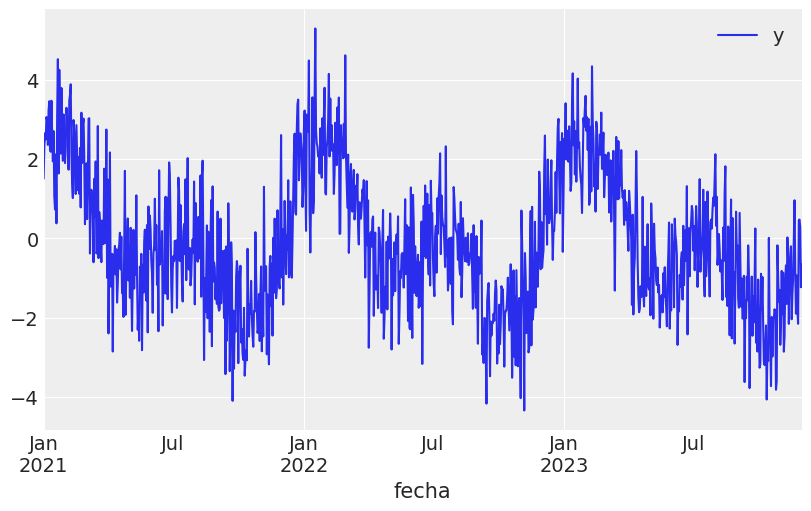

In [48]:
df.plot("fecha", "y")

### 0 - Scale the data

In [51]:
# Next, for the target variable, we divide by the maximum. We do this, rather 
# than standardising, so that the sign of the 
# observations in unchanged - this will be necessary for the seasonality 
# component to work properly later on.
y = df["y"].to_numpy()
y_max = np.max(y)
y = y / y_max

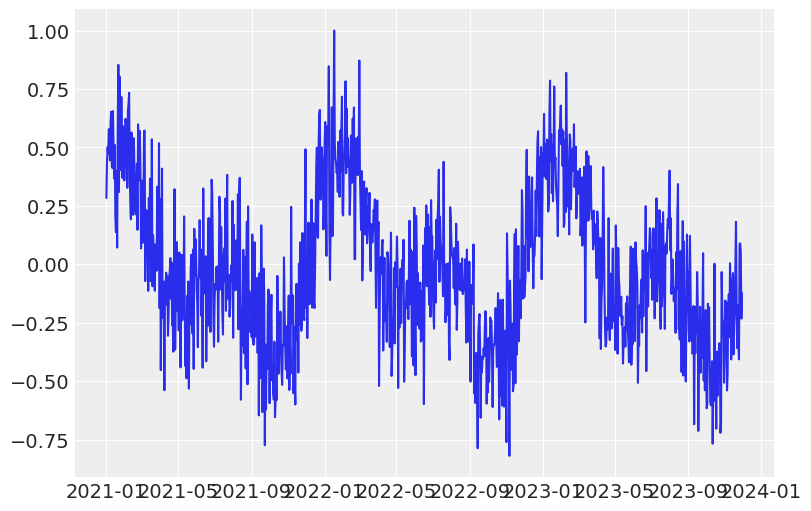

In [52]:
plt.plot(df['fecha'], y)

### 1 - Model

In [53]:
n_order = 2

coords = {'n_obs': df['fecha'],
          "fourier_features": np.arange(2 * n_order)}

with pm.Model(check_bounds=False, coords=coords) as seasonality_model:
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    beta_fourier = pm.Normal("beta_fourier", mu=0, sigma=0.5, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(beta_fourier, fourier_features.to_numpy().T),
        dims = "n_obs"
    )
    
    y_obs = pm.Normal("y_obs", mu=seasonality, sigma=sigma, observed=y, dims = "n_obs")

    seasonality_model_prior = pm.sample_prior_predictive()

Sampling: [beta_fourier, sigma, y_obs]


In [54]:
seasonality_model_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

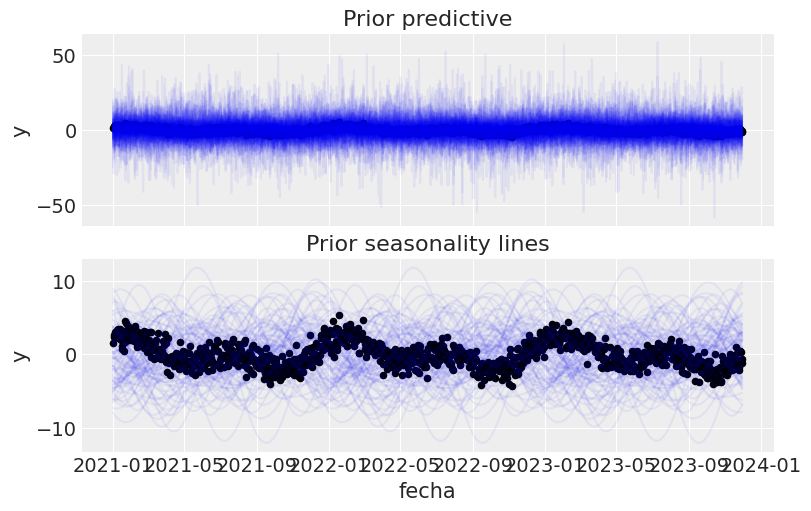

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(seasonality_model_prior, group="prior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(seasonality_model_prior, group="prior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[1])
ax[1].set_title("Prior seasonality lines");

In [57]:
with seasonality_model:
    # inference data, trace, posterior
    idata_s = pm.sample(
        return_inferencedata=True, 
        target_accept=0.9,
        draws=12000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True}
        )
    # ppc predictive check
    ppc_s = pm.sample_posterior_predictive(trace=idata_s)

Compiling...
Compilation time = 0:00:03.189409
Sampling...


  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

Sampling time = 0:00:08.948543
Transforming variables...
Transformation time = 0:00:01.052109
Computing Log Likelihood...
Log Likelihood time = 0:00:01.196509
Sampling: [y_obs]


In [58]:
idata_s

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [59]:
ppc_s

Inference data with groups:
	> posterior_predictive
	> observed_data

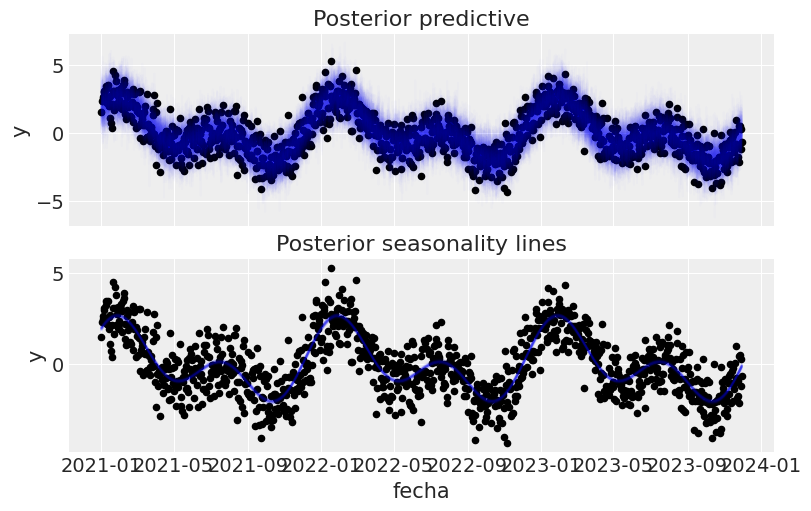

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(ppc_s, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(idata_s, group="posterior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[1])
ax[1].set_title("Posterior seasonality lines");

In [61]:
az.summary(idata_s, var_names=['beta_fourier', 'sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_fourier[0]  0.190  0.008   0.174    0.205        0.0      0.0   90401.0   
beta_fourier[1]  0.185  0.008   0.169    0.200        0.0      0.0   87950.0   
beta_fourier[2]  0.173  0.008   0.158    0.188        0.0      0.0   86663.0   
beta_fourier[3]  0.188  0.008   0.173    0.204        0.0      0.0   86453.0   
sigma            0.191  0.004   0.183    0.199        0.0      0.0   80700.0   

                 ess_tail  r_hat  
beta_fourier[0]   45964.0    1.0  
beta_fourier[1]   45762.0    1.0  
beta_fourier[2]   44225.0    1.0  
beta_fourier[3]   43797.0    1.0  
sigma             44907.0    1.0

In [62]:
az.summary(idata_s, var_names=['beta_fourier', 'sigma'])*y_max

mean        sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
beta_fourier[0]  1.007964  0.042441  0.923082  1.087540        0.0      0.0   
beta_fourier[1]  0.981438  0.042441  0.896557  1.061014        0.0      0.0   
beta_fourier[2]  0.917777  0.042441  0.838201  0.997353        0.0      0.0   
beta_fourier[3]  0.997353  0.042441  0.917777  1.082235        0.0      0.0   
sigma            1.013269  0.021220  0.970828  1.055709        0.0      0.0   

                      ess_bulk       ess_tail     r_hat  
beta_fourier[0]  479583.736205  243842.289919  5.305071  
beta_fourier[1]  466581.006839  242770.665548  5.305071  
beta_fourier[2]  459753.380281  234616.771205  5.305071  
beta_fourier[3]  458639.315341  232346.200756  5.305071  
sigma            428119.241068  238234.829723  5.305071

In [63]:
res = az.summary(ppc_s, var_names=['y_obs'])

c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\arviz\stats\stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


In [64]:
res

mean     sd  hdi_3%  hdi_97%  \
y_obs[2021-01-01T00:00:00.000000000]  0.371  0.191   0.010    0.731   
y_obs[2021-01-02T00:00:00.000000000]  0.380  0.191   0.018    0.735   
y_obs[2021-01-03T00:00:00.000000000]  0.390  0.191   0.034    0.749   
y_obs[2021-01-04T00:00:00.000000000]  0.396  0.192   0.026    0.749   
y_obs[2021-01-05T00:00:00.000000000]  0.406  0.192   0.036    0.759   
...                                     ...    ...     ...      ...   
y_obs[2023-11-26T00:00:00.000000000] -0.076  0.191  -0.433    0.285   
y_obs[2023-11-27T00:00:00.000000000] -0.061  0.192  -0.425    0.298   
y_obs[2023-11-28T00:00:00.000000000] -0.047  0.192  -0.404    0.317   
y_obs[2023-11-29T00:00:00.000000000] -0.035  0.191  -0.389    0.327   
y_obs[2023-11-30T00:00:00.000000000] -0.022  0.192  -0.378    0.344   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
y_obs[2021-01-01T00:00:00.000000000]      0.001    0.001   59642.0   59890.0   
y_obs[2021-01-02T00:00:00.000000000]      0.001    0.001   60287.0   59016.0   
y_obs[2021-01-03T00:00:00.000000000]      0.001    0.001   58952.0   59600.0   
y_obs[2021-01-04T00:00:00.000000000]      0.001    0.001   59827.0   57878.0   
y_obs[2021-01-05T00:00:00.000000000]      0.001    0.001   59426.0   58996.0   
...                                         ...      ...       ...       ...   
y_obs[2023-11-26T00:00:00.000000000]      0.001    0.001   58737.0   60354.0   
y_obs[2023-11-27T00:00:00.000000000]      0.001    0.001   59754.0   59384.0   
y_obs[2023-11-28T00:00:00.000000000]      0.001    0.001   59745.0   59788.0   
y_obs[2023-11-29T00:00:00.000000000]      0.001    0.001   60482.0   59516.0   
y_obs[2023-11-30T00:00:00.000000000]      0.001    0.001   60368.0   59807.0   

                                      r_hat  
y_obs[2021-01-01T00:00:00.000000000]    1.0  
y_obs[2021-01-02T00:00:00.000000000]    1.0  
y_obs[2021-01-03T00:00:00.000000000]    1.0  
y_obs[2021-01-04T00:00:00.000000000]    1.0  
y_obs[2021-01-05T00:00:00.000000000]    1.0  
...                                     ...  
y_obs[2023-11-26T00:00:00.000000000]    1.0  
y_obs[2023-11-27T00:00:00.000000000]    1.0  
y_obs[2023-11-28T00:00:00.000000000]    1.0  
y_obs[2023-11-29T00:00:00.000000000]    1.0  
y_obs[2023-11-30T00:00:00.000000000]    1.0  

[1064 rows x 9 columns]

In [65]:
res['mean']*y_max

y_obs[2021-01-01T00:00:00.000000000]    1.968181
y_obs[2021-01-02T00:00:00.000000000]    2.015927
y_obs[2021-01-03T00:00:00.000000000]    2.068978
y_obs[2021-01-04T00:00:00.000000000]    2.100808
y_obs[2021-01-05T00:00:00.000000000]    2.153859
                                          ...   
y_obs[2023-11-26T00:00:00.000000000]   -0.403185
y_obs[2023-11-27T00:00:00.000000000]   -0.323609
y_obs[2023-11-28T00:00:00.000000000]   -0.249338
y_obs[2023-11-29T00:00:00.000000000]   -0.185677
y_obs[2023-11-30T00:00:00.000000000]   -0.116712
Name: mean, Length: 1064, dtype: float64

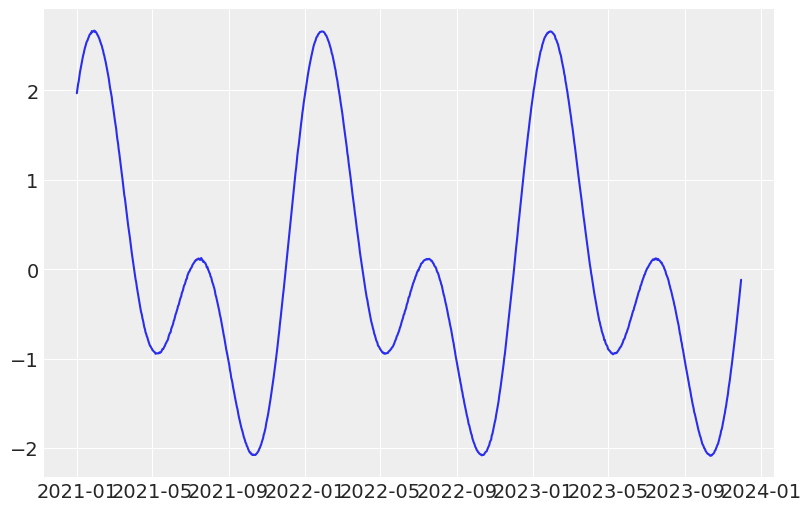

In [66]:
plt.plot(df["fecha"], res['mean']*y_max)

## Trend + Season

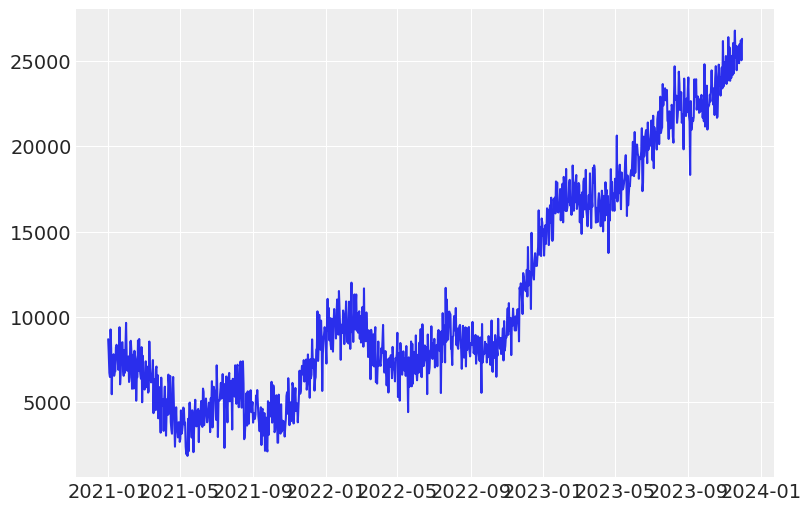

In [186]:
RANDOM_SEED = 11111
rng = np.random.default_rng(RANDOM_SEED)

df = pd.DataFrame(
    {
        "fecha": pd.date_range(start="2021-01-01", end="2023-11-30", freq="D")
    }
)

df = pd.concat([
    df, 
    stochastic_trend(
        rng, 
        N = df.shape[0], 
        sigma_local_trend = 1, 
        local_trend_0 = 1, 
        sigma_local_level = 1, 
        local_level_0 = 5000
        )
    ], 
               axis = 1)

fourier_features = make_fourier_features(df, "fecha", n_order=2, period=365.25)
fourier_coefs = np.array(fourier_features.shape[1]*[1.0])

df['yr_season'] = 1000 * np.dot(fourier_features, fourier_coefs)

df['y'] = df['local_level'] + df['yr_season'] + rng.normal(0, 1000, df.shape[0])

plt.plot(df["fecha"], df['y'])

In [187]:
df

fecha     t  local_trend   local_level    yr_season             y
0    2021-01-01     1    -0.521628   4999.398528  1987.052064   8690.128014
1    2021-01-02     2    -1.095988   4998.214240  2038.286110   7804.617002
2    2021-01-03     3    -3.458094   4995.419512  2088.006727   6725.387279
3    2021-01-04     4    -3.890317   4991.485024  2136.170004   6476.231599
4    2021-01-05     5    -4.609461   4986.525422  2182.733604   9265.666414
...         ...   ...          ...           ...          ...           ...
1059 2023-11-26  1060    29.593822  26168.834477  -452.734374  25985.802995
1060 2023-11-27  1061    30.075970  26199.439153  -385.338443  25257.872629
1061 2023-11-28  1062    30.314250  26230.267329  -317.278867  26211.444626
1062 2023-11-29  1063    29.727088  26261.563491  -248.614932  25041.950852
1063 2023-11-30  1064    30.602816  26292.005876  -179.406710  26300.214989

[1064 rows x 6 columns]

In [188]:
# STL decomposition
from statsmodels.tsa.seasonal import STL


In [189]:
aux = df[['fecha', 'y']].copy()
aux.set_index('fecha', inplace=True, drop = True)
# The decomposition requires 1 input, the data series. If the data series does 
# not have a frequency, then you must also specify period. The default value for 
# seasonal is 7, and so should also be changed in most applications.
aux = aux.asfreq('D')


c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\statsmodels\tsa\seasonal.py:359: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


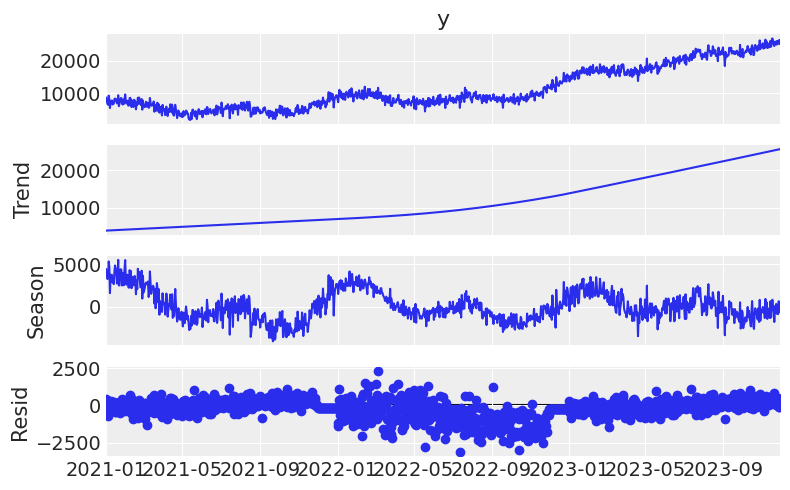

In [190]:
stl = STL(aux['y'], period=365)
res = stl.fit()
fig = res.plot()

### 0 - Scale the data

In [191]:
# Next, for the target variable, we divide by the maximum. We do this, rather 
# than standardising, so that the sign of the 
# observations in unchanged - this will be necessary for the seasonality 
# component to work properly later on.
y = df["y"].to_numpy()
y_max = np.max(y)
y = y / y_max

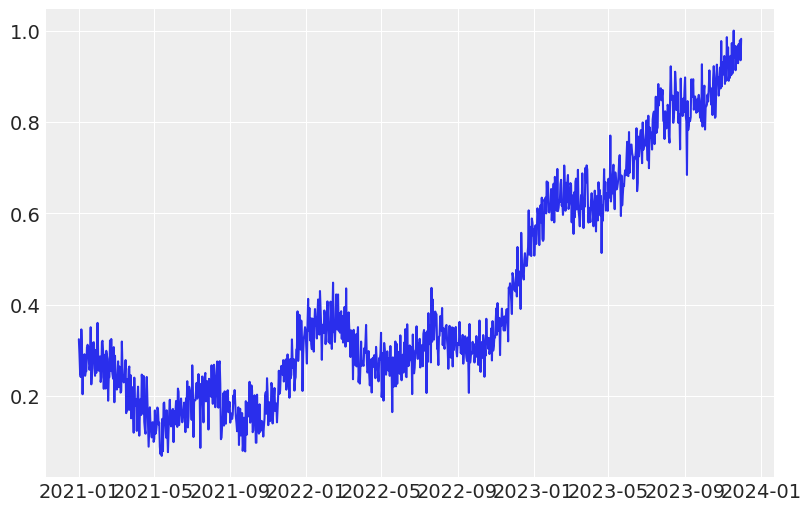

In [192]:
plt.plot(df["fecha"], y)

### 1 - Model

In [193]:
T = y.shape[0]

sigma_lt_0 = 1 / 4 / T

mu_ll_0 = y[0]
sigma_ll_0 = 0.68 * (1 - y_min/y_max)

sigma_lt = np.std(np.diff(y))
sigma_ll = sigma_lt

sigma_epsilon = np.std(y)

print(f"y_max      = {y_max}")
print(f"y_min      = {y_min}")
print(f"T          = {T}")
print(f"sigma_lt_0 = {sigma_lt_0}")
print(f"mu_ll_0    = {mu_ll_0}")
print(f"sigma_ll_0 = {sigma_ll_0}")
print(f"sigma_lt   = {sigma_lt}, lam_lt = {1 / sigma_lt}")
print(f"sigma_ll   = {sigma_ll}, lam_ll = {1 / sigma_ll}")

print(f"sigma   = {sigma_epsilon}, lam_sigma = {1 / sigma_epsilon}")

y_max      = 26780.901571835104
y_min      = 37.043551505720224
T          = 1064
sigma_lt_0 = 0.00023496240601503758
mu_ll_0    = 0.3244897484380511
sigma_ll_0 = 0.6790594187071588
sigma_lt   = 0.05206413168308825, lam_lt = 19.207081106949975
sigma_ll   = 0.05206413168308825, lam_ll = 19.207081106949975
sigma   = 0.24261246381806387, lam_sigma = 4.121799780038936


In [194]:
n_order = 2

coords = {'n_obs': df['fecha'],
          "fourier_features": np.arange(2 * n_order)}

with pm.Model(coords=coords, check_bounds=False) as trend_season_model:

    # sigma_local_trend = pm.Exponential("sigma_local_trend", lam=y_max * 1)  # 20
    # sigma_local_level = pm.Exponential("sigma_local_level", lam=y_max * 1)  # 20
    # sigma             = pm.Exponential("sigma", lam=y_max * 1)              # .1
    sigma_local_trend = pm.Exponential("sigma_local_trend", lam=1/sigma_lt)
    sigma_local_level = pm.Exponential("sigma_local_level", lam=1/sigma_ll)  
    sigma             = pm.Exponential("sigma", lam=1/sigma_epsilon)              

    # local_trend_0    = pm.Normal("local_trend_0", mu=0, sigma=1e-1)
    local_trend_0    = pm.Normal("local_trend_0", mu=0, sigma=sigma_lt_0)
    diff_local_trend = pm.Normal("diff_local_trend", mu=0, sigma=sigma_local_trend, dims="n_obs")
    local_trend      = pm.Deterministic("local_trend", diff_local_trend.cumsum() + local_trend_0, dims="n_obs")
    
    # local_level_0    = pm.Normal("local_level_0", mu=0, sigma=.5)
    local_level_0    = pm.Normal("local_level_0", mu=mu_ll_0, sigma=sigma_ll_0)
    diff_local_level = pm.Normal("diff_local_level", mu=local_trend, sigma=sigma_local_level, dims="n_obs")
    local_level      = pm.Deterministic("local_level", diff_local_level.cumsum() + local_level_0, dims="n_obs")
    
    beta_fourier = pm.Normal("beta_fourier", mu=0, sigma=.5, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(beta_fourier, fourier_features.to_numpy().T),
        dims = "n_obs"
    )
    
    mu = pm.Deterministic("mu", local_level + seasonality, dims = "n_obs")

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, dims="n_obs", observed=y)

    trend_season_prior = pm.sample_prior_predictive()

Sampling: [beta_fourier, diff_local_level, diff_local_trend, local_level_0, local_trend_0, sigma, sigma_local_level, sigma_local_trend, y_obs]


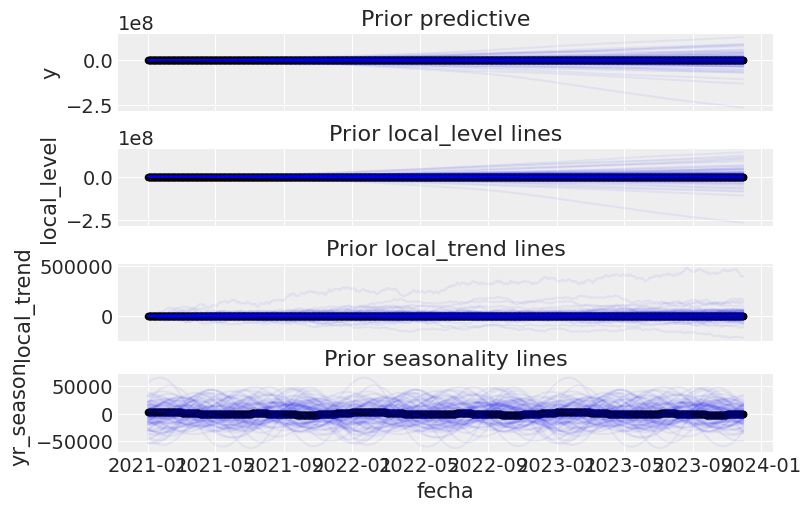

In [195]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(trend_season_prior, group="prior_predictive", num_samples=100)["y_obs"]* y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(trend_season_prior, group="prior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Prior local_level lines");

ax[2].plot(
    df["fecha"],
    az.extract(trend_season_prior, group="prior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="local_trend", color="k", ax=ax[2])
ax[2].set_title("Prior local_trend lines");


ax[3].plot(
    df["fecha"],
    az.extract(trend_season_prior, group="prior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="yr_season", color="k", ax=ax[3])
ax[3].set_title("Prior seasonality lines");

In [196]:
with trend_season_model:
    # inference data, trace, posterior
    idata_s_t = pm.sample(
        return_inferencedata=True, 
        # target_accept=0.9,
        draws=1000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True}
        )
    # ppc predictive check
    ppc_s_t = pm.sample_posterior_predictive(trace=idata_s_t)

Compiling...
Compilation time = 0:00:02.113382
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:03:21.488116
Transforming variables...
Transformation time = 0:00:01.623726
Computing Log Likelihood...
Log Likelihood time = 0:00:00.955655
Sampling: [y_obs]


In [197]:
idata_s_t

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [198]:
ppc_s_t

Inference data with groups:
	> posterior_predictive
	> observed_data

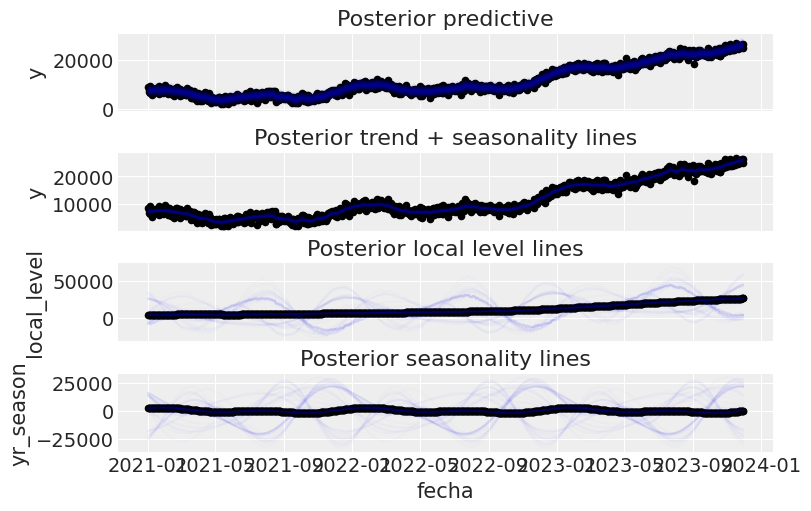

In [199]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(ppc_s_t, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(idata_s_t, group="posterior", num_samples=100)["mu"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[1])
ax[1].set_title("Posterior trend + seasonality lines");

ax[2].plot(
    df["fecha"],
    az.extract(idata_s_t, group="posterior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="local_level", color="k", ax=ax[2])
ax[2].set_title("Posterior local level lines");

ax[3].plot(
    df["fecha"],
    az.extract(idata_s_t, group="posterior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="yr_season", color="k", ax=ax[3])
ax[3].set_title("Posterior seasonality lines");

In [200]:
az.summary(idata_s_t, var_names=['~mu', "~seasonality", "~diff_local_trend", "~diff_local_level", "~local_level", "~local_trend"])*y_max

mean            sd        hdi_3%       hdi_97%  \
local_trend_0        -0.000000      0.000000     -0.000000      0.000000   
local_level_0      8409.203094  11355.102266  -7471.871539  31601.463855   
beta_fourier[0]    -803.427047   4552.753267  -8918.040223   8650.231208   
beta_fourier[1]    1553.292291   9292.972845 -14649.153160  17755.737742   
beta_fourier[2]     107.123606   6695.225393 -17380.805120  11622.911282   
beta_fourier[3]   -2329.938437   5061.590397 -13872.507014   1687.196799   
sigma_local_trend    53.561803    160.685409      0.000000     80.342705   
sigma_local_level   214.247213    214.247213     26.780902    562.398933   
sigma               964.112457     80.342705    856.988850   1044.455161   

                     mcse_mean      mcse_sd      ess_bulk      ess_tail  \
local_trend_0         0.000000     0.000000  1.392607e+06  4.392068e+06   
local_level_0      4900.904988  3749.326220  1.874663e+05  2.945899e+05   
beta_fourier[0]    1633.634996  1205.140571  2.678090e+05  2.945899e+05   
beta_fourier[1]    4043.916137  3026.241878  1.606854e+05  2.945899e+05   
beta_fourier[2]    2838.775567  2115.691224  1.606854e+05  2.945899e+05   
beta_fourier[3]    2062.129421  1553.292291  1.874663e+05  5.356180e+05   
sigma_local_trend    53.561803    26.780902  1.606854e+05  3.213708e+05   
sigma_local_level   107.123606    80.342705  1.606854e+05  3.213708e+05   
sigma                26.780902    26.780902  2.142472e+05  4.284944e+05   

                          r_hat  
local_trend_0      28387.755666  
local_level_0      58650.174442  
beta_fourier[0]    46330.959719  
beta_fourier[1]    62131.691647  
beta_fourier[2]    66148.826882  
beta_fourier[3]    52222.758065  
sigma_local_trend  69898.153102  
sigma_local_level  86234.503061  
sigma              43117.251531

## 2 - Prophet-like

### 0 - Scale the data

In [82]:
df

fecha     t  local_trend   local_level    yr_season             y
0    2021-01-01     1    -0.521628    999.398528  1987.052064   4690.128014
1    2021-01-02     2    -1.095988    998.214240  2038.286110   3804.617002
2    2021-01-03     3    -3.458094    995.419512  2088.006727   2725.387279
3    2021-01-04     4    -3.890317    991.485024  2136.170004   2476.231599
4    2021-01-05     5    -4.609461    986.525422  2182.733604   5265.666414
...         ...   ...          ...           ...          ...           ...
1059 2023-11-26  1060    29.593822  22168.834477  -452.734374  21985.802995
1060 2023-11-27  1061    30.075970  22199.439153  -385.338443  21257.872629
1061 2023-11-28  1062    30.314250  22230.267329  -317.278867  22211.444626
1062 2023-11-29  1063    29.727088  22261.563491  -248.614932  21041.950852
1063 2023-11-30  1064    30.602816  22292.005876  -179.406710  22300.214989

[1064 rows x 6 columns]

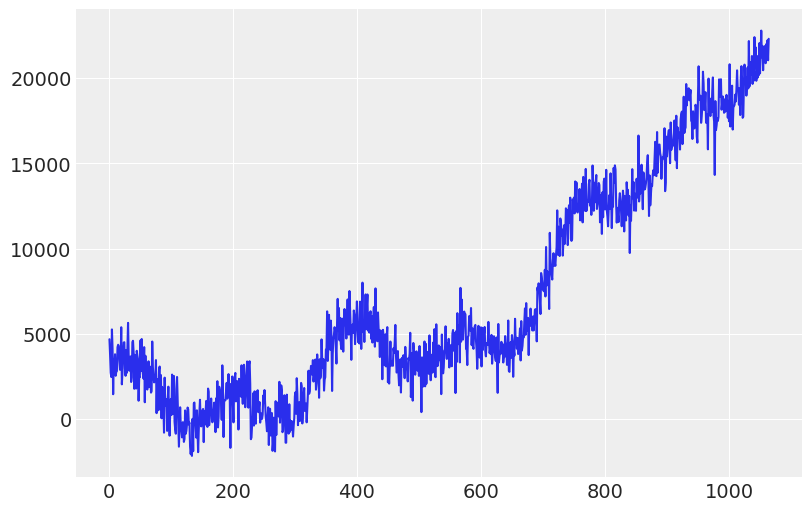

In [108]:
plt.plot(df['t'], df['y'])

In [205]:
# Max-min scaling
# 
y = df["y"].to_numpy()
y_max = np.max(y)
y = y / y_max

t = df['t']
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

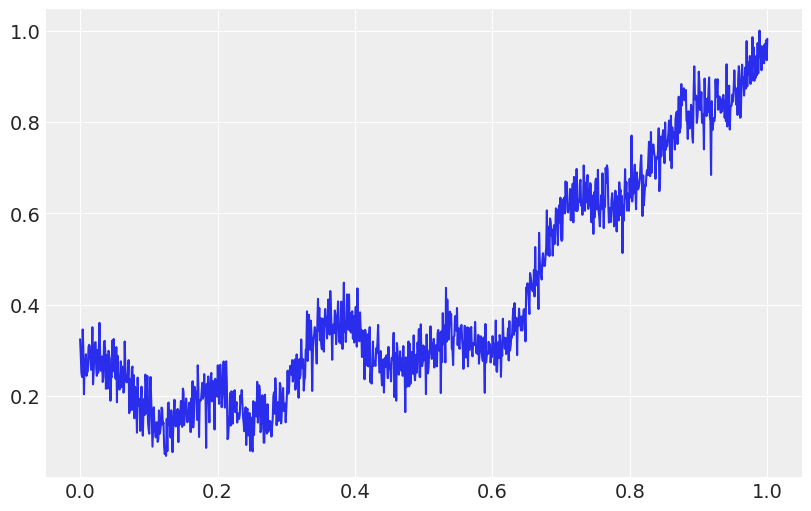

In [206]:
plt.plot(t, y)

### 1 - Model

In [247]:
coords = {'n_obs': df['fecha'],
          "fourier_features": np.arange(2 * n_order)}

with pm.Model(check_bounds=False, coords=coords) as linear_with_seasonality:
    
    X_data = pm.MutableData('X_data', t)
    y_data = pm.MutableData('y_data', y)

    alpha = pm.HalfNormal("alpha", sigma=2)
    beta  = pm.Normal("beta",  mu=0, sigma=1)
    k     = pm.Uniform("k", lower=0.1, upper=4) 
    sigma = pm.HalfNormal("sigma", sigma = 5)

    beta_fourier = pm.Normal("beta_fourier", mu=0, sigma=1, dims="fourier_features")

    seasonality = pm.Deterministic(
        "seasonality", 
        pm.math.dot(beta_fourier, fourier_features.to_numpy().T),
        dims = "n_obs"
    )

    trend = pm.Deterministic("trend", alpha + beta * (X_data**k), dims="n_obs")
    # mu = pm.Deterministic("mu", trend * (1 + seasonality), dims="n_obs")
    mu = pm.Deterministic("mu", trend + seasonality, dims="n_obs")

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)

    prior_pc = pm.sample_prior_predictive()

Sampling: [alpha, beta, beta_fourier, k, sigma, y_obs]


In [248]:
prior_pc

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [249]:
az.extract(prior_pc, group="prior", num_samples=100)["beta"].mean() *y_max

<xarray.DataArray 'beta' ()>
array(3810.68009986)

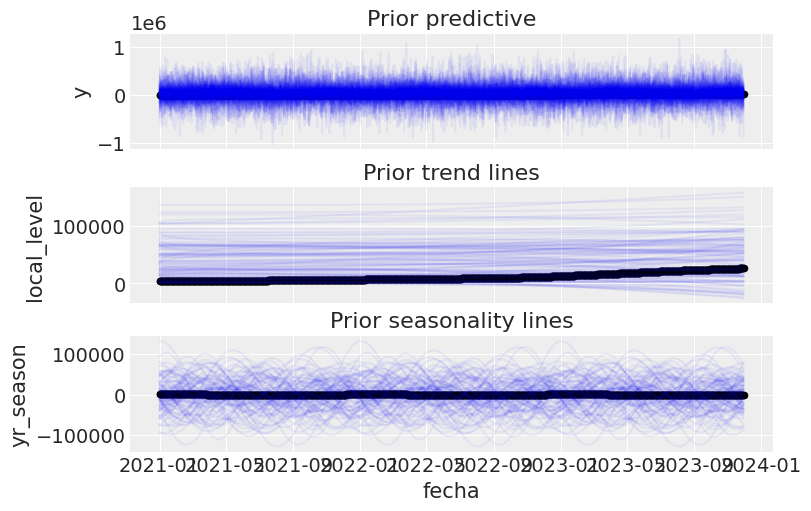

In [251]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(prior_pc, group="prior_predictive", num_samples=100)["y_obs"]* y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(prior_pc, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");

ax[2].plot(
    df["fecha"],
    az.extract(prior_pc, group="prior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="yr_season", color="k", ax=ax[2])
ax[2].set_title("Prior seasonality lines");


In [272]:
with linear_with_seasonality:
    # inference data, trace, posterior
    idata_l_s = pm.sample(
        return_inferencedata=True, 
        target_accept=0.9,
        draws=10000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True}
        )
    # ppc predictive check
    posterior_pc_l_s = pm.sample_posterior_predictive(trace=idata_l_s)

Compiling...
Compilation time = 0:00:01.739052
Sampling...


  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

Sampling time = 0:00:13.596582
Transforming variables...
Transformation time = 0:00:03.668114
Computing Log Likelihood...
Log Likelihood time = 0:00:02.761512
Sampling: [y_obs]


In [273]:
idata_l_s

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [274]:
posterior_pc_l_s

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

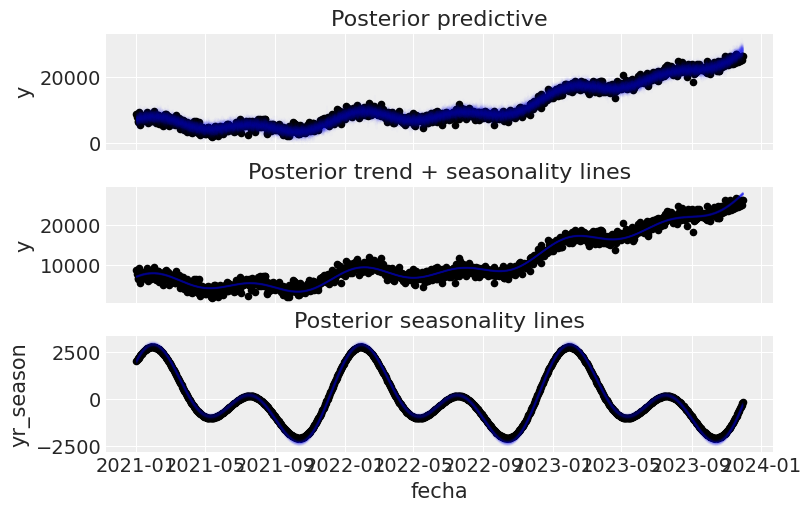

In [275]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(posterior_pc_l_s, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(idata_l_s, group="posterior", num_samples=100)["mu"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[1])
ax[1].set_title("Posterior trend + seasonality lines");

ax[2].plot(
    df["fecha"],
    az.extract(idata_l_s, group="posterior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="yr_season", color="k", ax=ax[2])
ax[2].set_title("Posterior seasonality lines");


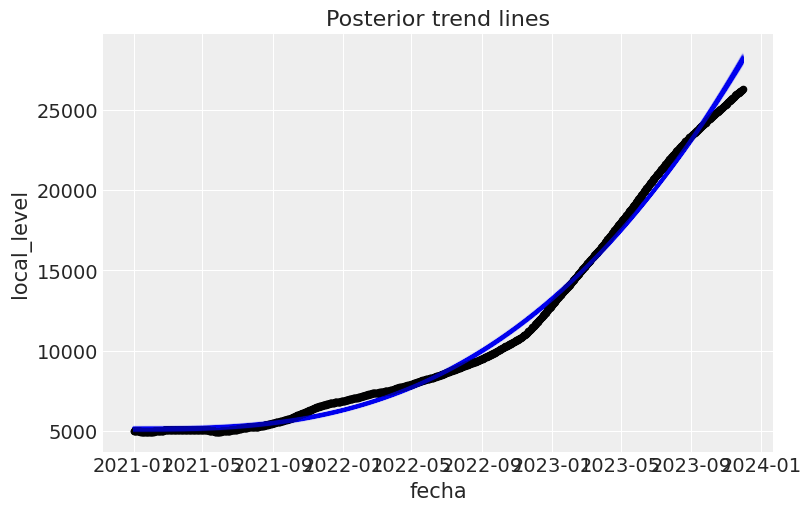

In [276]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

ax.plot(
    df["fecha"],
    az.extract(idata_l_s, group="posterior", num_samples=1000)["trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="local_level", color="k", ax=ax)
ax.set_title("Posterior trend lines");

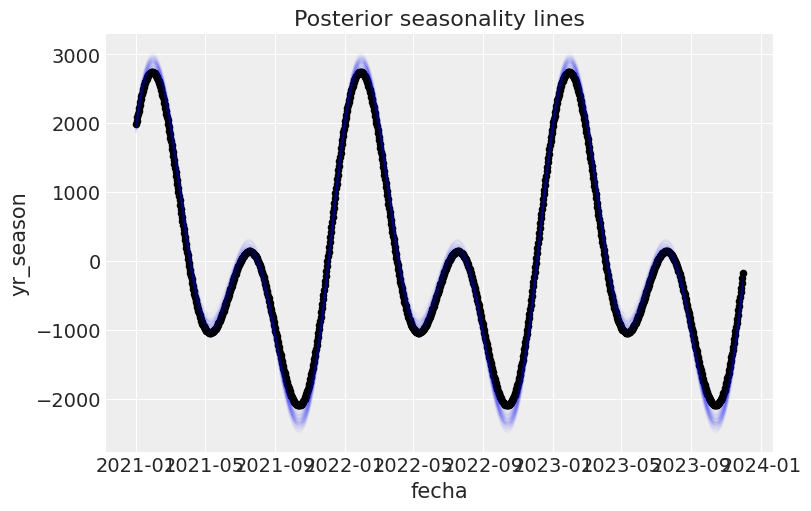

In [277]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

ax.plot(
    df["fecha"],
    az.extract(idata_l_s, group="posterior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="yr_season", color="k", ax=ax)
ax.set_title("Posterior seasonality lines");

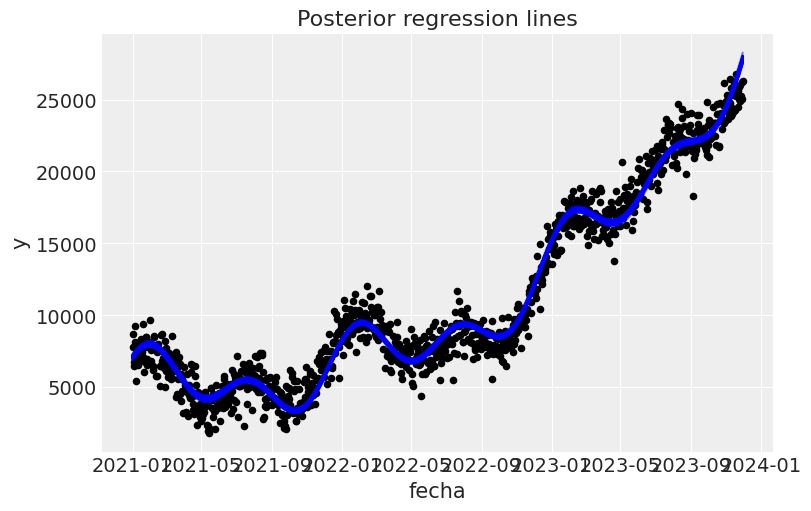

In [278]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

ax.plot(
    df["fecha"],
    az.extract(idata_l_s, group="posterior", num_samples=100)["mu"] * y_max,
    color="blue",
    alpha=0.5,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax)
ax.set_title("Posterior regression lines");

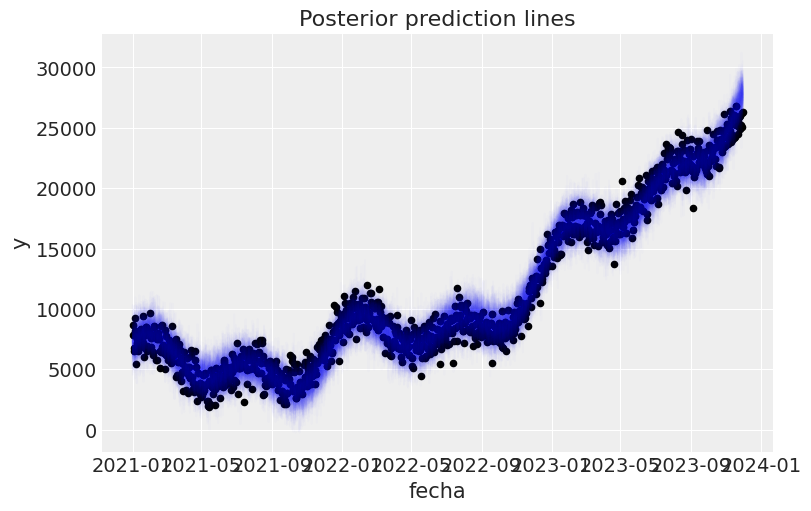

In [280]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

ax.plot(
    df["fecha"],
    az.extract(posterior_pc_l_s, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax)
ax.set_title("Posterior prediction lines");

In [283]:
az.summary(idata_l_s, var_names=['~mu', "~seasonality", "~trend", "~k", ], kind = "stats")*y_max

mean          sd        hdi_3%       hdi_97%
beta             23031.575352  133.904508  22790.547238  23299.384367
beta_fourier[0]   1178.359669   53.561803   1098.016964   1285.483275
beta_fourier[1]    964.112457   53.561803    883.769752   1071.236063
beta_fourier[2]   1071.236063   53.561803    964.112457   1151.578768
beta_fourier[3]   1044.455161   53.561803    937.331555   1124.797866
alpha             5115.152200   53.561803   4981.247692   5222.275807
sigma             1098.016964   26.780902   1044.455161   1151.578768

In [282]:
az.summary(idata_l_s, var_names=['k', ])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
k  2.78  0.034   2.716    2.844        0.0      0.0   19018.0   24607.0    1.0

# Probatinas

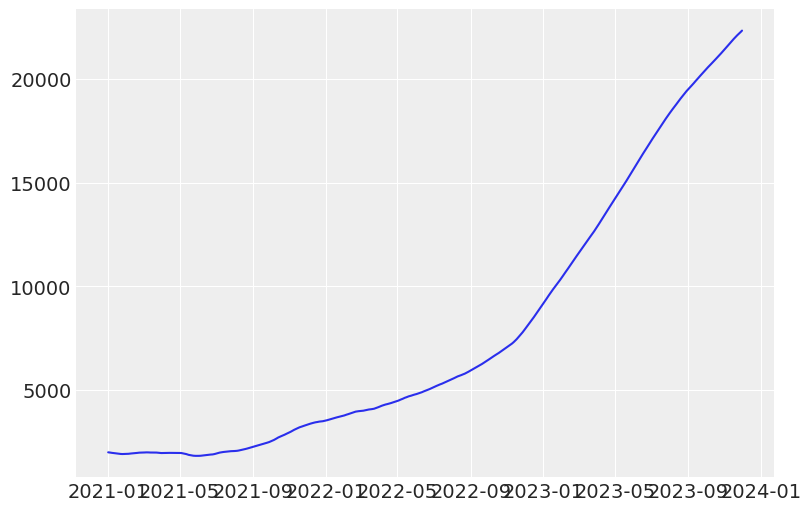

In [159]:
RANDOM_SEED = 11111
rng = np.random.default_rng(RANDOM_SEED)

df = pd.DataFrame(
    {
        "fecha": pd.date_range(start="2021-01-01", end="2023-11-30", freq="D")
    }
)

df = pd.concat([
    df, 
    stochastic_trend(
        rng, 
        N = df.shape[0], 
        sigma_local_trend = 1, 
        local_trend_0 = 1, 
        sigma_local_level = 1, 
        local_level_0 = 1000
        )
    ], 
               axis = 1)

plt.plot(df['fecha'], df['local_level'])

In [155]:
df

fecha     t  local_trend  local_level
0    2021-01-01     1     0.847837  2000.767994
1    2021-01-02     2     0.790401  2001.470094
2    2021-01-03     3     0.554191  2002.687651
3    2021-01-04     4     0.510968  2003.154449
4    2021-01-05     5     0.439054  2003.243361
...         ...   ...          ...          ...
1059 2023-11-26  1060     3.859382  5097.729504
1060 2023-11-27  1061     3.907597  5102.165807
1061 2023-11-28  1062     3.931425  5106.611158
1062 2023-11-29  1063     3.872709  5112.052941
1063 2023-11-30  1064     3.960282  5115.852792

[1064 rows x 4 columns]

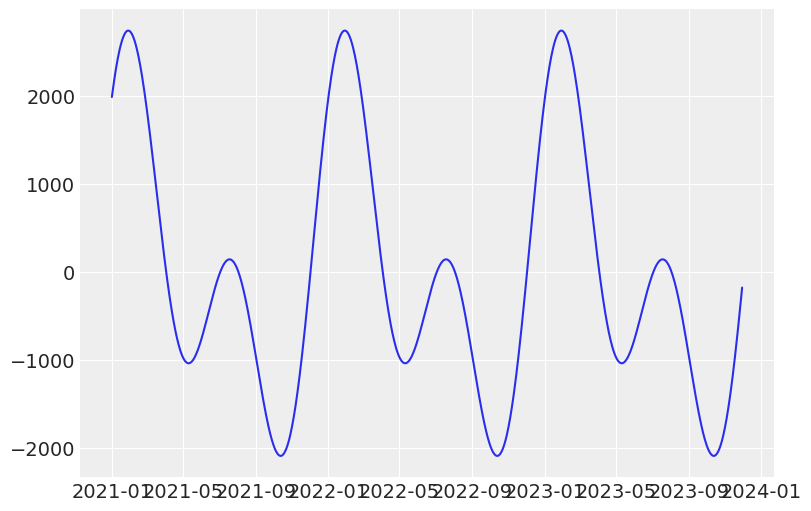

In [156]:
fourier_features = make_fourier_features(df, "fecha", n_order=2, period=365.25)
fourier_coefs = np.array(fourier_features.shape[1]*[1000.0])

df['yr_season'] = np.dot(fourier_features, fourier_coefs)

plt.plot(df['fecha'], df['yr_season'])

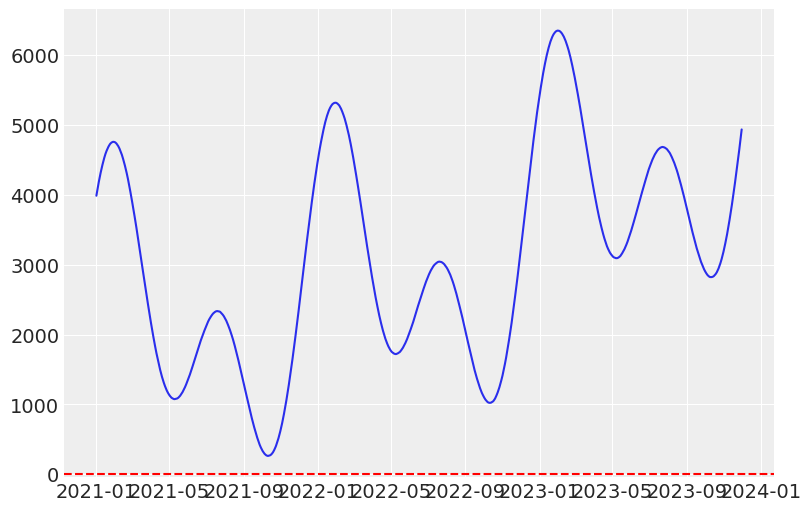

In [157]:
df['trnd_season'] = df['local_level'] + df['yr_season']

plt.plot(df['fecha'], df['trnd_season'])
plt.axhline(y=0, color='r', linestyle='--')

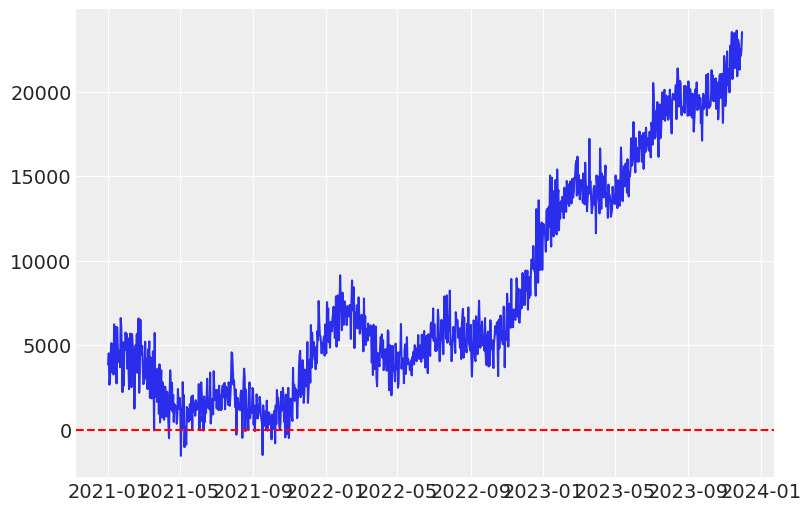

In [153]:
df['y'] = df['trnd_season'] + rng.normal(0, 1000, df.shape[0])

plt.plot(df["fecha"], df['y'])
plt.axhline(y=0, color='r', linestyle='--')

In [182]:
# https://marubon-ds.blogspot.com/2018/01/local-linear-trend-model-for-time.html
# 
N = len(y)

coords = {'n_obs': df.index}

with pm.Model(coords=coords, check_bounds=False) as stochastic_trend_model_2:
    
    # X_data = pm.MutableData('X_data', t)
    Y_data = pm.MutableData('Y_data', y)
    
    sigma_local_trend = pm.Exponential("sigma_local_trend", lam=1/sigma_lt)  
    sigma_local_level = pm.Exponential("sigma_local_level", lam=1/sigma_ll)  
    sigma             = pm.Exponential("sigma", lam=1/sigma_epsilon)              

    local_trend_0    = pm.Normal("local_trend_0", mu=0, sigma=sigma_lt_0)
    local_level_0    = pm.Normal("local_level_0", mu=mu_ll_0, sigma=sigma_ll_0)
    
    local_level_aux  = pm.GaussianRandomWalk("local_level_aux", mu = local_level_0, sigma = sigma_local_level, dims="n_obs")
    local_trend_aux  = pm.GaussianRandomWalk("local_trend_aux", mu = 0, sigma = sigma_local_trend, dims="n_obs")
    
    local_trend = pm.Deterministic("local_trend", local_trend_aux + local_trend_0, dims="n_obs")
    local_level = pm.Normal("local_level", mu = local_level_aux[:-1] + local_trend_aux[:-1], sigma = sigma_local_level, dims="n_obs")

    y_obs = pm.Normal("y_obs", mu=local_level, sigma=sigma, dims="n_obs", observed=Y_data)

    stochastic_trend_prior_2 = pm.sample_prior_predictive()



c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Sampling: [local_level, local_level_0, local_level_aux, local_trend_0, local_trend_aux, sigma, sigma_local_level, sigma_local_trend, y_obs]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (100,) and arg 1 with shape (99,).
Apply node that caused the error: normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1682B0B19A0>), [100], 11, Add.0, sigma_local_level)
Toposort index: 14
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(int64, shape=()), TensorType(float64, shape=(99,)), TensorType(float64, shape=())]
Inputs shapes: ['No shapes', (1,), (), (99,), ()]
Inputs strides: ['No strides', (8,), (), (8,), ()]
Inputs values: [Generator(PCG64) at 0x1682B0B19A0, array([100], dtype=int64), array(11, dtype=int64), 'not shown', array(0.01206876)]
Outputs clients: [['output'], ['output', normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1682B0B26C0>), [100], 11, local_level, sigma)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.